# Fit the complete data (With sWeights and without sWeights)
- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)

Those two fits are not simultaneous

## Import

In [1]:
import zfit
import json
import numpy as np

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']


In [3]:
df = fct.load_data(years, magnets, type_data='common', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/all_common.root


In [4]:
name_data = 'all_common_cutDeltaM_V8_fixedTails'
name_data_B0Ds = 'all_common_cutDeltaM_Ds_weighted_V8'

## Fit on weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [5]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

In [6]:
name_data_B0Ds = 'all_common_cutDeltaM_Ds_weighted_V8'
low_B0Ds = 5150.
high_B0Ds = 5360.

weights =  fct.retrieve_pickle('all_common_cutDeltaM_Ds_V8')

### Distributions

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:634: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


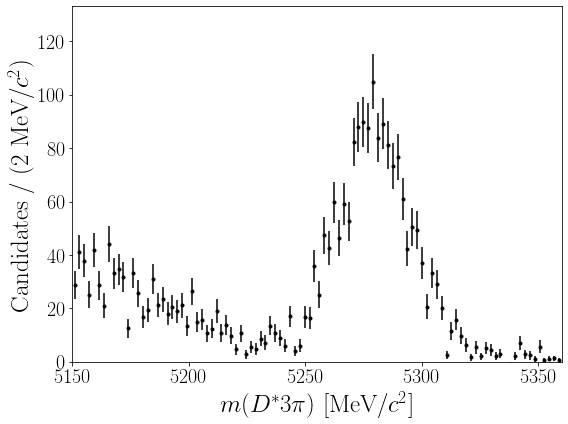

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_common_cutDeltaM_Ds_weighted_V8.pdf


In [7]:
fct.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weights.sig)

### Intial values

In [8]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = 1600
n_bkg_k = 200
n_bkg2_k = 800

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5279.                         , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.000001                     , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

### Observables and variables

In [9]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = {}
for var in initial_values_B0Ds.keys():
    zparams_B0Ds[var] = zfit.Parameter(var,
                                      initial_values_B0Ds[var]['value'], 
                                      initial_values_B0Ds[var]['low'], 
                                      initial_values_B0Ds[var]['high'],
                                      floating = initial_values_B0Ds[var]['floating'])

In [10]:
name_params_B0Ds = {
    # Signal
    f'mu_B0Ds'      : '$\mu_S$',
    f'sigma_B0Ds'   : '$\\sigma_S$',
    f'n_sig_B0Ds'   : '$n_S$',
    # Combinatorial background
    f'n_bkg_B0Ds'   : '$n_{B,c}$',
    f'lambda_B0Ds'  : '$\\lambda_{B,c}$',
    # Partially reconstructed background
    f'mu2_B0Ds'     : '$\\mu_{B, D^* D_s h}$',
    f'sigma2_B0Ds'  : '$\\sigma_{B, D^* D_s h}$',
    f'n_bkg2_B0Ds'  : '$n_{B, D^* D_s h}$',
}

### PDFs

In [11]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=weights.sig)

### Fitting

In [13]:
import timeit
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
#result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4938                   |      Ncalls=99 (99 total)      |
| EDM = 0.000371 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name              value    minuit_hesse    at limit
-----------  ----------  --------------  ----------
n_sig_B0Ds         1564     +/-      45       False
n_bkg_B0Ds        200.1     +/-      72 

Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4938                   |     Ncalls=163 (163 total)     |
    | EDM = 0.000956 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.8     +/-      73  -     37   +1.6e+02       False
    n_bkg2_B0Ds       812.9     +/-      60  -1.5e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.45   +   0.44       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -2.289e-07     +/- 8.2e-05  - 0.0059   +   0.02       False
    sigma2_B0Ds       76.21     +/-       4  -    4.6   +    3.4       False
    Time to do the fit:  28.78929978515953

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4938                   |      Ncalls=99 (99 total)      |
    | EDM = 0.000371 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.1     +/-      72  -     36   +1.6e+02       False
    n_bkg2_B0Ds         813     +/-      59  -1.4e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.44   +   0.45       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -1.241e-07     +/- 2.7e-05  - 0.0059   +  0.016       False
    sigma2_B0Ds       76.26     +/-       4  -    4.6   +    3.3       False
    Time to do the fit:  26.363226884044707



/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:634: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


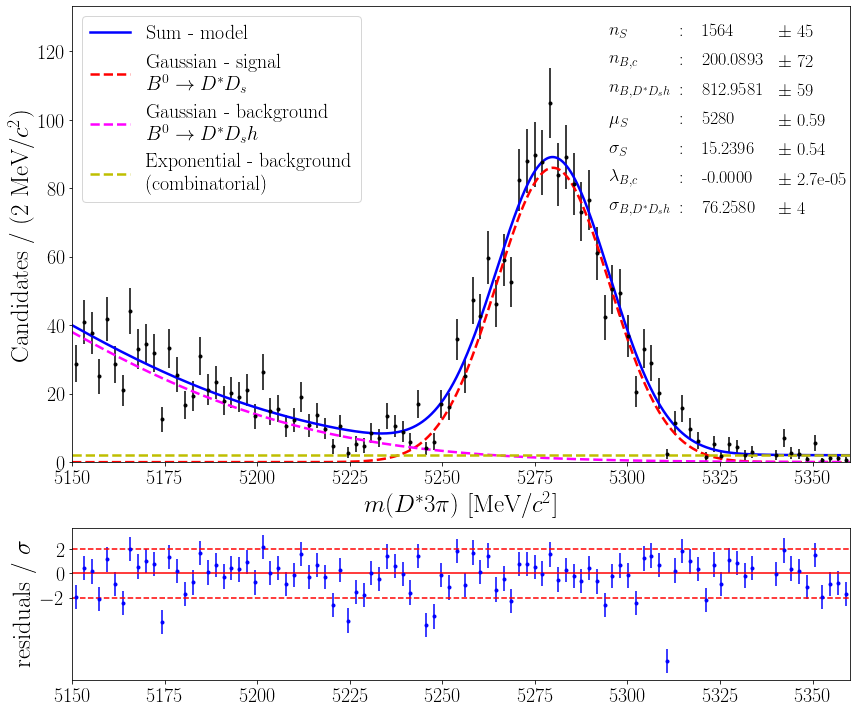

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_common_cutDeltaM_V8_fixedTails/B0_M_all_common_cutDeltaM_Ds_weighted_V8_fit.pdf


/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:634: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


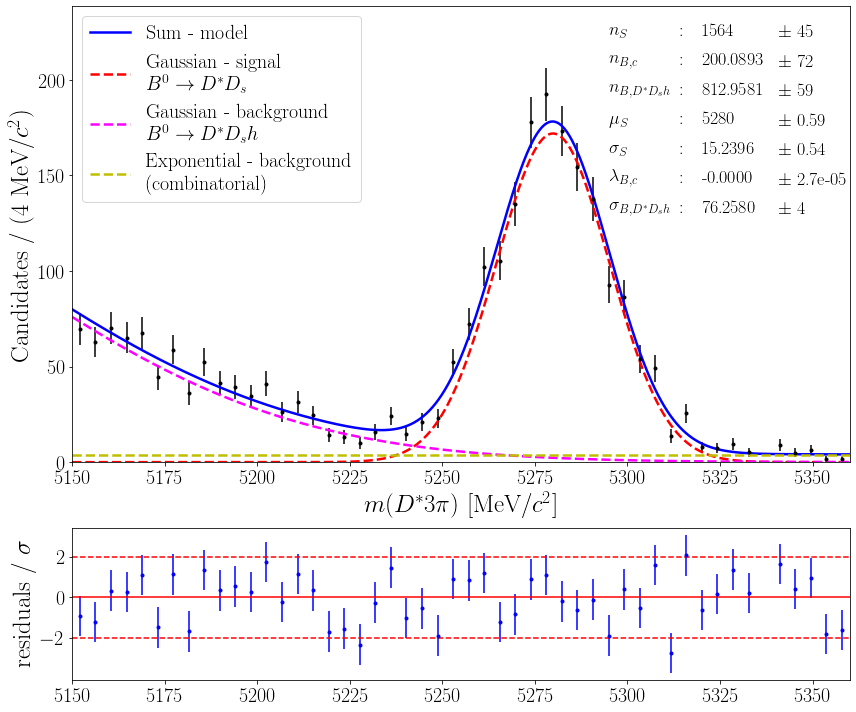

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_common_cutDeltaM_V8_fixedTails/B0_M_all_common_cutDeltaM_Ds_weighted_V8_50_fit.pdf


In [17]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=weights.sig,
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=20)
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 50,mode_hist = False,
                       name_data = name_data_B0Ds+'_50', name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=weights.sig,
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=20)

In [19]:
save_params(params_B0Ds, name_data_B0Ds, True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_weighted_V8_params.json


## Fit on the full `B0_M`

In [8]:
low = 5150.
high = 5550.

### Data

In [9]:
# Result of the fit on the MC D0S->D*pipipi data with one of the pi misidentified as a kaon
with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
    data_KPiPi_params = json.load(f)

for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    
    
# Result of the previous fit on the B0_M sWeighted distribution with cut on tau_M around m(Ds)
with open(f'{loc.JSON}/{name_data_B0Ds}_params.json', 'r') as f:
    data_B0Ds_params = json.load(f)
    
# Result of the fit on the MC signal data
with open(f'{loc.JSON}/MC_params.json', 'r') as f:
    MC_param_results = json.load(f)

### Distribution

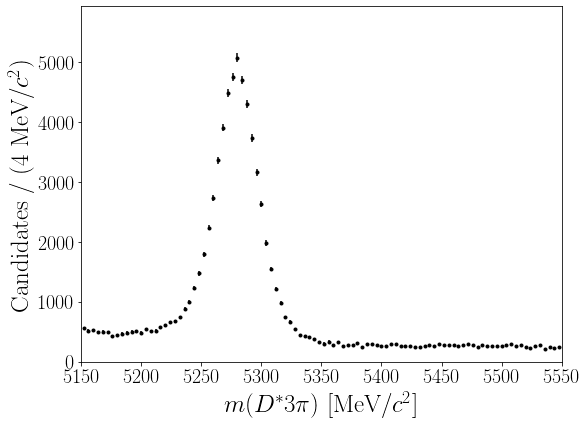

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_V8_fixedTails_B0_cut.pdf


In [10]:
fct.plot_hist_particle({name_data+'_B0_cut':df},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black')

### Initial values

In [11]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = 58000
n_bkg_k = 28000
n_bkg2_k = 590
n_bkgK_k = 3000

initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
    'sigmaR'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                 , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.0008                       , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': 80.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
#     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    'r_bkgK'   :{ 'value': n_bkgK_k/n_sig_k              , 'low': 0.0001          , 'high': 0.5                   , 'floating': True},
}

## More narrow initial conditions
# A very little bit faster
# initial_values = {
#     # Signal        
#     'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
#     'sigmaL'   :{ 'value': 17.9                          , 'low': 10.            , 'high': 25.                  , 'floating': True},
#     'sigmaR'   :{ 'value': 17.9                          , 'low': 15.            , 'high': 30.                  , 'floating': True},
#     'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
#     'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.           , 'high': -0.1                 , 'floating': False},
#     'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
#     'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
#     'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                 , 'floating': True},
#     'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Combinatorial background        
#     'lambda'   :{ 'value': -0.0008                       , 'low': -0.001         , 'high': -0.0001             , 'floating': True},
#     'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Partially reconstructed particles        
#     'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2'   :{ 'value': 36.                           , 'low': 10.            , 'high': 60.                  , 'floating': True},
#     'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     # Background decay D*Kpipi    
# #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     'r_bkgK'   :{ 'value': n_bkgK_k/n_sig_k              , 'low': 0.001          , 'high': 0.5                   , 'floating': True},
# }


for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}

for var in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{var}_B0Ds'] = {'value': data_B0Ds_params[f'{var}_B0Ds'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [12]:
obs = zfit.Space("x", limits=(low, high))

zparams = {}
for var in initial_values.keys():
    zparams[var] = zfit.Parameter(var,
                                  initial_values[var]['value'], 
                                  initial_values[var]['low'], 
                                  initial_values[var]['high'],
                                  floating = initial_values[var]['floating'])

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

In [13]:
name_params = {
    # Signal
    'mu'      : '$\mu_S$',
    'sigmaL'  : '$\\sigma_{L_S}$',
    'sigmaR'  : '$\\sigma_{R_S}$',    
    'alphaL'  : '$\\alpha_{L_S}$',
    'alphaR'  : '$\\alpha_{R_S}$',
    'nL'      : '$n_L_S$',
    'nR'      : '$n_R_S$',
    'frac'    : '$f_{S, \\frac{L}{R}}$',
    'n_sig'   : '$n_S$',
    # Combinatorial background
    'n_bkg'   : '$n_{B,c}$',
    'lambda'  : '$\\lambda_{B,c}$',
    # Partially reconstructed brackground
    'mu2'     : '$\\mu_{B,D^*3\pi h}$',
    'sigma2'  : '$\\sigma_{B,D^*3\pi h}$',
    'n_bkg2'  : '$n_{B,D^*3\pi h}$',
    # Background decay D*Kpipi    
    'n_bkgK'  : '$n_{B,D^*K\pi\pi}$',
    'r_bkgK'  : '$\\frac{n_{B,D^*K\pi\pi}}{n_S}$',
}


### PDFs

In [14]:
def crystall_ball_gaussian(mu, sigma, obs, alpha=None, n=None):
    if alpha is None or n is None:
        pdf = zfit.pdf.Gauss(mu, sigma, obs=obs)
    else:
        pdf = zfit.pdf.CrystalBall(mu, sigma, alpha, n, obs=obs)
    return pdf

def sum_crystalball(muL, muR, sigmaL, sigmaR, frac, obs, alphaL=None, alphaR=None, nL=None, nR=None):
    """ Return the sum of 2 crystall ball PDFs.
    If the alpha or n is None, the corresponding distribution is a gaussian.
    """
    pdfL = crystall_ball_gaussian(muL, sigmaL, obs,
                                         alphaL,nL)
    pdfR = crystall_ball_gaussian(muR, sigmaR, obs,
                                         alphaR, nR)
    
    model = zfit.pdf.SumPDF([pdfL, pdfR], fracs=frac)
    
    return model, pdfL, pdfR

In [15]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_B0Ds'],zparams['sigma_B0Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_B0Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df['B0_M'], obs=obs)

### Fit

In [16]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.257e+05              |     Ncalls=901 (901 total)     |
| EDM = 0.000406 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse    at limit
------  ----------  --------------  ----------
n_sig        51950     +/- 3.9e+02       False
n_bkg2       374.4     +/-      98       False
r_bkgK  

**$\alpha_R$ can vary**

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |    Ncalls=1248 (1248 total)    |
    | EDM = 0.00017 (Goal: 0.001)   |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        52920     +/- 4.6e+02  -4.6e+02   +4.8e+02       False
    n_bkg2       529.3     +/- 1.1e+02  -1.1e+02   +1.3e+02       False
    r_bkgK     0.06047     +/-  0.0076  - 0.0081   + 0.0077       False
    n_bkg        27600     +/- 5.9e+02  -6.6e+02   +6.8e+02       False
    frac        0.3079     +/-   0.045  -  0.042   +  0.046       False
    mu            5280     +/-    0.11  -   0.12   +   0.11       False
    sigmaL       12.82     +/-     0.7  -   0.67   +    0.7       False
    alphaR      -1.666     +/-   0.093  -  0.094   +  0.093       False
    sigmaR       21.16     +/-    0.34  -   0.32   +   0.35       False
    sigma2       36.08     +/-     4.5  -    4.3   +    5.1       False
    lambda  -0.0003618     +/- 0.00016  -0.00019   +0.00019       False
    Time to do the fit:  109.48165091499686


**$\alpha_L$ and $\alpha_R$ can vary**

Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |    Ncalls=1291 (1291 total)    |
    | EDM = 0.000767 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        56520     +/- 5.2e+02  -5.9e+02   +5.2e+02       False
    n_bkg2       739.8     +/- 1.7e+02  -1.6e+02   +1.9e+02       False
    r_bkgK   3.793e-07     +/- 0.00011  - 0.0076   + 0.0063       False
    n_bkg        26990     +/- 5.3e+02  -5.3e+02   +6.5e+02       False
    frac        0.4716     +/-   0.078  -  0.055   +  0.078       False
    alphaL      0.8723     +/-    0.15  -   0.11   +   0.15       False
    mu            5279     +/-    0.16  -   0.17   +   0.17       False
    sigmaL       17.46     +/-    0.65  -   0.65   +   0.65       False
    alphaR      -1.193     +/-   0.084  -  0.069   +  0.084       False
    sigmaR       17.38     +/-    0.43  -   0.35   +   0.43       False
    sigma2       41.38     +/-     5.4  -      5   +    5.4       False
    lambda  -0.0002177     +/- 0.00015  -0.00018   +0.00018       False
    Time to do the fit:  274.34758268200676

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |     Ncalls=202 (202 total)     |
    | EDM = 0.000487 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        56520     +/- 5.2e+02  -5.2e+02   +5.2e+02       False
    n_bkg2       740.2     +/- 1.8e+02  -1.6e+02   +1.8e+02       False
    r_bkgK   2.981e-08     +/- 2.9e-05  - 0.0071   + 0.0062       False
    n_bkg        26990     +/- 5.4e+02  -5.4e+02   +6.5e+02       False
    frac        0.4716     +/-   0.073  -  0.055   +  0.061       False
    alphaL      0.8723     +/-    0.14  -   0.11   +   0.14       False
    mu            5279     +/-    0.17  -   0.17   +   0.17       False
    sigmaL       17.46     +/-    0.62  -   0.62   +   0.65       False
    alphaR      -1.193     +/-    0.08  -  0.069   +   0.08       False
    sigmaR       17.38     +/-     0.4  -   0.35   +    0.4       False
    sigma2       41.35     +/-     5.5  -      5   +    5.8       False
    lambda  -0.0002176     +/- 0.00015  -0.00018   +0.00018       False
    Time to do the fit:  205.58939155300322

**All the left tail parameters are fixed**

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |     Ncalls=901 (901 total)     |
    | EDM = 0.000406 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse    at limit
    ------  ----------  --------------  ----------
    n_sig        51950     +/- 3.9e+02       False
    n_bkg2       374.4     +/-      98       False
    r_bkgK     0.03279     +/-  0.0077       False
    n_bkg        30230     +/- 4.9e+02       False
    frac         0.366     +/-   0.045       False
    mu            5280     +/-    0.11       False
    sigmaL       12.93     +/-    0.54       False
    sigmaR       21.82     +/-    0.38       False
    sigma2       33.46     +/-     5.1       False
    lambda  -0.0009778     +/- 0.00013       False
    Time to do the fit:  21.091739206109196



/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:549: UserWarning: The function <function Space.limits at 0x7f1b701b85f0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:37: UserWarning: The function <function Space.area at 0x7f1b701bd9e0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


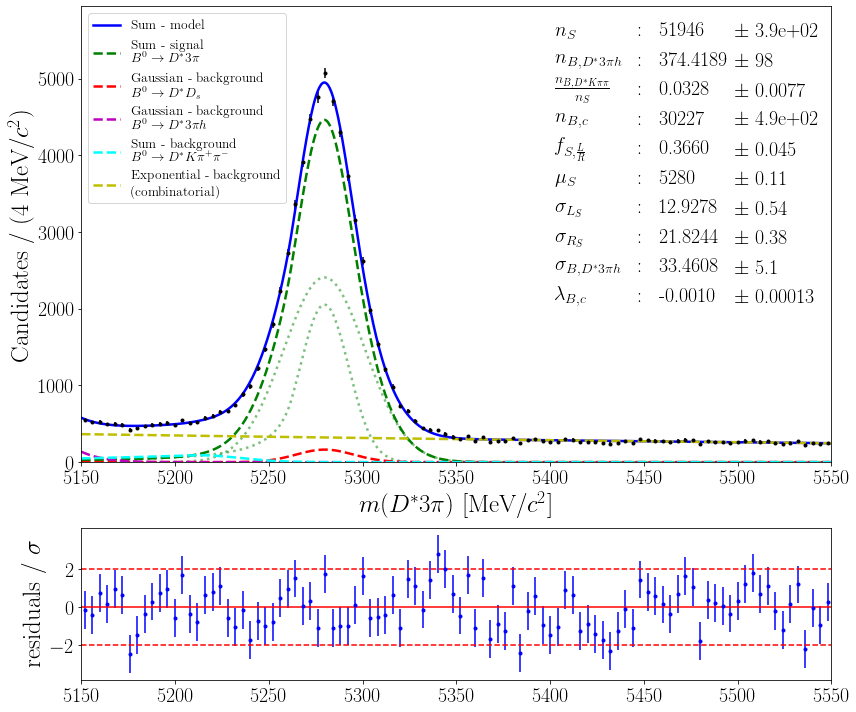

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_fixedTails/B0_M_all_data_strip_cutDeltaM_V8_fixedTails_details_fit.pdf


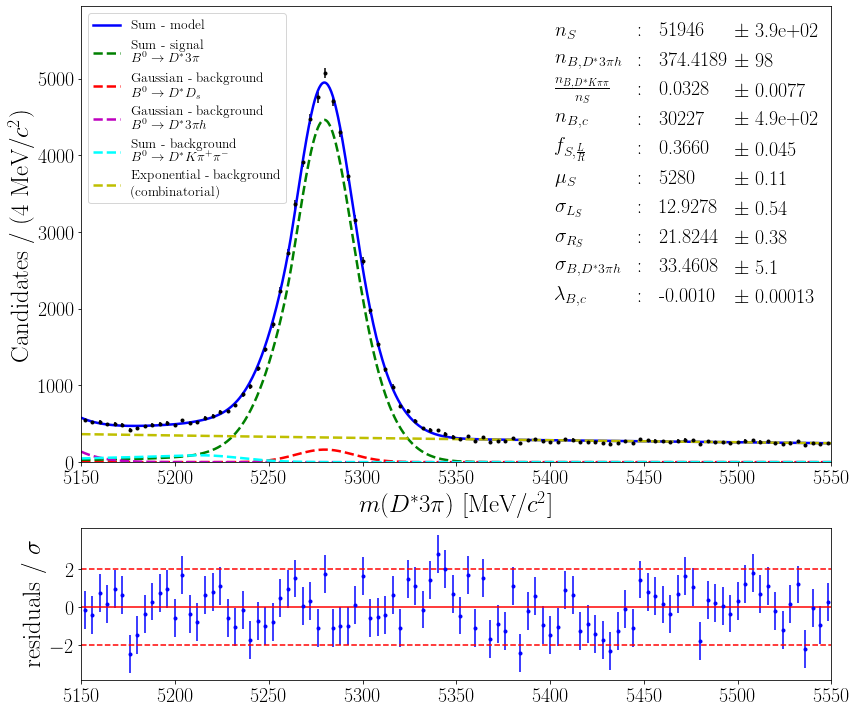

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_fixedTails/B0_M_all_data_strip_cutDeltaM_V8_fixedTails_fit.pdf


In [17]:
name_data_plot = name_data + '_details'
plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )
name_data_plot = name_data
plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )

In [18]:
save_params(params,name_data, True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_V8_fixedTails_params.json
